In [ ]:
!pip install -q transformers 

In [1]:
import torch
import torch.nn as nn 
import numpy as np
from torch.utils.data import DataLoader , Dataset
import pandas as pd 
from tqdm import tqdm 
from transformers import BertModel , BertTokenizer, AdamW ,  get_linear_schedule_with_warmup , set_seed
from pylab import rcParams
import seaborn as sns 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split , KFold , StratifiedKFold
import random 
import numpy as np

2021-11-15 10:52:13.719170: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def seed_all(seed_value):
    random.seed(seed_value) 
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

seed =42
seed_all(seed)

In [3]:
class Config:
    NB_EPOCHS = 4
    LR = 3e-5
    EPS=1e-8
    MAX_LEN = 110
    N_SPLITS = 4
    TRAIN_BS = 60
    VALID_BS = 40
    MODEL_NAME = 'bert-base-cased'
    TRAIN_FILE = '../input/gvbclean/Mytrain.csv'
    TEST_FILE = '../input/gvbclean/Test.csv'
    SUB_FILE = '../input/genderbasedviolence/SampleSubmission.csv'
    TOKENIZER = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
rcParams["figure.figsize"] = 12,8

In [7]:
df =  pd.read_csv(Config.TRAIN_FILE)
df.head()

,tweet,type
0,none because my husband always beats me to it.,Physical_violence
1,to what did he say? let me lead? she got rapid...,sexual_violence
2,the fuck is wrong with you? and liking this ki...,sexual_violence
3,he rapid me from on top😭,sexual_violence
4,"if my boyfriend or husband beats me, i don't e...",Physical_violence


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='type', ylabel='count'>

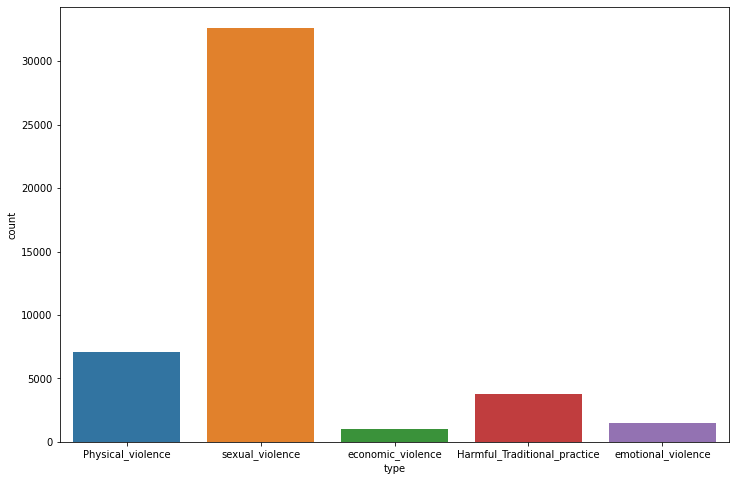

In [8]:
sns.countplot(df.type)

In [9]:
labels_ord = ['Harmful_Traditional_practice','Physical_violence', 'economic_violence', 'emotional_violence','sexual_violence']
df['label'] = df.type.astype('category').cat.codes

Y = to_categorical(df['label'])

for i in range(len(labels_ord)) :     
     df[labels_ord[i]] = Y[:,i]

In [10]:
df.head(3)

,tweet,type,label,Harmful_Traditional_practice,Physical_violence,economic_violence,emotional_violence,sexual_violence
0,none because my husband always beats me to it.,Physical_violence,1,0.0,1.0,0.0,0.0,0.0
1,to what did he say? let me lead? she got rapid...,sexual_violence,4,0.0,0.0,0.0,0.0,1.0
2,the fuck is wrong with you? and liking this ki...,sexual_violence,4,0.0,0.0,0.0,0.0,1.0


### We can count the max lenght size 

In [11]:
tokenizer = BertTokenizer.from_pretrained(Config.MODEL_NAME)

In [12]:
token_lens = []

for txt in df.tweet:
    tokens = tokenizer.encode(txt , max_length=512)
    token_lens.append(len(tokens)) 

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

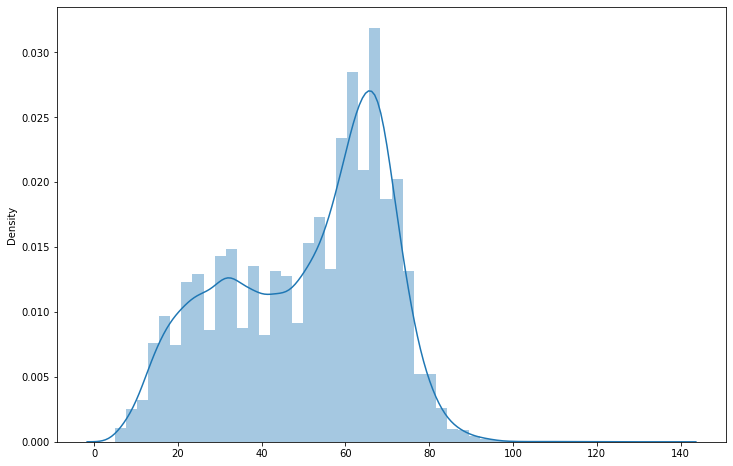

In [13]:
sns.distplot(token_lens) 

In [14]:
class GBVDataset(Dataset):
    def __init__(self, tweets, targets=None, is_test=False):
        self.tweets = tweets
        self.targets = targets
        self.is_test = is_test
        self.tokenizer = Config.TOKENIZER
        self.max_len = Config.MAX_LEN
    
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, idx):
        tweet = str(self.tweets[idx])
        tweet = ' '.join(tweet.split())
        global inputs
       
        inputs = self.tokenizer(
                            tweet,
                            add_special_tokens=True,
                            max_length=self.max_len,
                            padding="max_length" ,
                            truncation = True ,
                            pad_to_max_length=True, 
                            )
        
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        token_type = torch.tensor(inputs['token_type_ids'], dtype=torch.long)
     
        
   
        if self.is_test:
            return {
                'ids': ids,
                'mask': mask,
                'token_type':token_type
               
            }
        else:    
            targets = torch.tensor(self.targets[idx], dtype=torch.long)
            return {
                'ids': ids,
                'mask': mask,
                'token_type':token_type,
                'targets': targets
            }

In [15]:
def GBVDataloader(df  , batch_size , is_test=False):
    dataset = GBVDataset(df["tweet"].values , df["label"].values  , is_test)
    dataloader = DataLoader(dataset , batch_size , shuffle=False)
    return dataloader

In [17]:
dataloader = GBVDataloader(df , 1)

In [18]:
data = next(iter(dataloader))

In [19]:
data

{'ids': tensor([[  101,  3839,  1272,  1139,  2252,  1579, 11883,  1143,  1106,  1122,
            119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]),
 'mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0

In [ ]:
""""
class GBVClassifier(nn.Module):
    def __init__(self , n_classes):
        super(GBVClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(Config.MODEL_NAME , return_dict=False)
        self.drop1=  nn.Dropout(p=0.7)
        self.drop2=  nn.Dropout(p=0.8)
        self.out = nn.Linear(768,n_classes)
        

    def forward(self , input_ids, attention_mask ,token_type_ids):
        
        _,sortie = self.bert(input_ids,attention_mask,token_type_ids)

        output1 = self.drop1(sortie)
        output1 = self.out(output1)
        
        output2 = self.drop2(sortie)
        output2 = self.out(output2)
        
        output= output1.add(output2)/2
     
        
        return output
        
""" 

In [20]:
class GBVClassifier(nn.Module):
    def __init__(self , n_classes):
        super(GBVClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(Config.MODEL_NAME , return_dict=False)
        self.drop=  nn.Dropout(p=0.8)
        self.out = nn.Linear(768,n_classes)
        

    def forward(self , input_ids, attention_mask ,token_type_ids):
        
        _,pooledout = self.bert(input_ids,attention_mask,token_type_ids)

        output = self.drop(pooledout)
        output = self.out(output)
        
        return output

In [21]:
model = GBVClassifier(len(labels_ord))
model.to(device)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GBVClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [22]:
def loss_fn(outputs, labels):
     
    return nn.CrossEntropyLoss()(outputs, labels)

def yield_optimizer(model):
    """
    Returns optimizer for specific parameters
    """
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    return AdamW(optimizer_parameters, lr=Config.LR, eps=Config.EPS) 

In [23]:
def train_epoch (model , data_loader , loss_fn , optimizer , device , scheduler , n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for step , d in tqdm(enumerate(data_loader) , total=len(data_loader)):
        
        input_ids =d['ids'].to(device) 
        token_type_ids = d['token_type'].to(device)
        attention_mask = d['mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
             input_ids ,
            attention_mask ,
            token_type_ids)
        
        _, pred =  torch.max(outputs , dim=1)

        loss = loss_fn(outputs , targets)
        correct_predictions +=torch.sum(pred ==targets)
        losses.append(loss.item())


        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples  , np.mean(losses)

In [24]:
def eval_model (model , data_loader , loss_fn , device , n_examples):
    
    model.eval()
  
    losses = []
    correct_predictions = 0

    with torch.no_grad() :
        
        for step , d in tqdm(enumerate(data_loader) , total=len(data_loader)):
            
            input_ids =d['ids'].to(device)
            token_type_ids = d['token_type'].to(device)
            attention_mask = d['mask'].to(device)
            targets = d['targets'].to(device)
        
            outputs = model(
                   input_ids ,
                attention_mask ,
                token_type_ids  )

            _, pred =  torch.max(outputs , dim=1)
            loss = loss_fn(outputs , targets)
            correct_predictions +=torch.sum(pred ==targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples  , np.mean(losses)


In [25]:
def train(model , df , epochs):
    
    
    best_accuracy = 0
    some_val =0
    
    for epoch in range(epochs):

        print(f'Epoch {epoch + 1}')

        kf = StratifiedKFold(n_splits=4, random_state=seed, shuffle=False)

        for step , (train, valid ) in enumerate(kf.split(df , df["label"])) :
          
            train_data_loader= GBVDataloader(df.iloc[train],Config.TRAIN_BS)
            validation_data_loader = GBVDataloader(df.iloc[valid],Config.VALID_BS)

            nb_train_steps = int(len(train_data_loader) /Config.TRAIN_BS * epochs)
            optimizer = yield_optimizer(model)
            scheduler = get_linear_schedule_with_warmup(
                                        optimizer,
                                        num_warmup_steps=0,
                                        num_training_steps=nb_train_steps)

            train_acc,train_loss = train_epoch(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(df.iloc[train])) 
            
            print(f"Train accuracy {train_acc} ,Train Loss {train_loss}")
                
            val_acc, val_loss = eval_model(model,validation_data_loader,loss_fn,device,len(df.iloc[valid]))
            
            print(f"Validation accuracy {val_acc} , Validation loss {val_loss}")

          
            if  val_acc > best_accuracy:

                torch.save(model.state_dict(),'best_model.bin')
                best_accuracy = val_acc
                print(f"Best accuracy {best_accuracy}")

In [26]:
#train(model , df , Config.NB_EPOCHS)

In [ ]:
## For Real time use Config.NB_EPOCHS instead 1
train(model , df , 1)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Epoch 1


100%|██████████| 576/576 [06:14<00:00,  1.54it/s]


Train accuracy 0.5546157634041075 ,Train Loss 1.2504192625896797


100%|██████████| 288/288 [00:50<00:00,  5.74it/s]


Validation accuracy 0.7090719499478624 , Validation loss 1.0509338372697432
Best accuracy 0.7090719499478624


 66%|██████▌   | 380/576 [04:07<02:13,  1.46it/s]

In [ ]:
test = pd.read_csv(Config.TEST_FILE)
test

In [ ]:
test = test[['tweet']]
test

In [ ]:
model = GBVClassifier(len(labels_ord))
model.load_state_dict(torch.load('./best_model.bin'))
model = model.to(device)

In [ ]:
def TweetTestDataloader(df  , batch_size , is_test=True):
    dataset = GBVDataset(df["tweet"].values ,None  , is_test)
    dataloader = DataLoader(dataset , batch_size , shuffle=False)
    return dataloader

In [ ]:
testdataloader = TweetTestDataloader(test  , 1)

In [ ]:
proba= []

In [ ]:
def get_predictions(model, df_test):
    
    model = model.eval()
  
    predictions = []
  
    data_loader = TweetTestDataloader(df_test  , 1)
   
    with torch.no_grad():
        for d in data_loader:
            
            input_ids = d["ids"].to(device)
            attention_mask = d["mask"].to(device)
            token_type_ids = d["token_type"].to(device)
            
            outputs = model(
                            input_ids,
                            attention_mask ,
                            token_type_ids
                              )
            proba.append(outputs)
            _, preds = torch.max(outputs, dim=1)
   

In [ ]:
get_predictions(model ,test)

In [ ]:
tab=[]

In [ ]:
for i in proba:
    tab.append(i.flatten().tolist())

In [ ]:
predict_pd = pd.DataFrame(data=tab , columns=labels_ord)

In [ ]:
 predict_pd

In [ ]:
#predict_pd["economic_violence"] = predict_pd["economic_violence"]*3.999 
#predict_pd["emotional_violence"] = predict_pd["emotional_violence"]*3.999 
#predict_pd["Harmful_Traditional_practice"] = predict_pd["Harmful_Traditional_practice"]*3.75 

In [ ]:
#predict_pd["economic_violence"] = predict_pd["economic_violence"]*0.999 
predict_pd["sexual_violence"] = predict_pd["sexual_violence"]*3.35
#predict_pd["Harmful_Traditional_practice"] = predict_pd["Harmful_Traditional_practice"]*0.998  

In [ ]:
#predict_pd["economic_violence"] = predict_pd["economic_violence"]*0.20
predict_pd["Physical_violence"] = predict_pd["Physical_violence"]*2.75
#predict_pd["Harmful_Traditional_practice"] = predict_pd["Harmful_Traditional_practice"]*0.998 

In [ ]:
get_prediction = predict_pd.idxmax(axis=1)

In [ ]:
sub = pd.read_csv("../input/genderbasedviolence/SampleSubmission.csv")

In [ ]:
sub.head()

In [ ]:
sub["type"]= get_prediction

In [ ]:
sub

In [ ]:
sub.to_csv("MA-FAAA10.csv",index=False)